# CODE TO IMPORT FOUNDATION MODEL

In [ ]:
!git clone https://github.com/plana93/ARGO_Vision_CODEMOTION_2025.git
!pip install -e ARGO_Vision_CODEMOTION_2025


Cloning into 'ARGO_Vision_CODEMOTION_2025'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 217 (delta 11), reused 1 (delta 0), pack-reused 192 (from 1)
Receiving objects: 100% (217/217), 36.33 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Obtaining file:///content/ARGO_Vision_CODEMOTION_2025
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for CODEMOTION_2025 (pyproject.toml) ... done
  Created wheel for CODEMOTION_2025: filename=codemotion_2025-0.1.0-0.editable-py3-none-any.whl size=2903 sha256=15b2ec82398d6933997de4c078b2710ab962210f20644bb622091b1443a72aef
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvvx4a_6/wheels/5b/cb/24/68e4d6865367b2eb40d237767b8b626120727f49411638f36e
Succes

In [ ]:
import sys
import os
sys.path.append("../")
sys.path.append("./ARGO_Vision_CODEMOTION_2025")
from pathlib import Path

import numpy as np
import torch

import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

from codemotion2025.utils.download_image import download_image_from_url
from codemotion2025.utils.dinov3_utils import (
    load_model_dinov3,
    get_dinov3_transform_preserving_aspect_ratio,
    extract_from_layer_dinov3,
    compute_similarity_map,
    extract_mask,
    compute_bbox_from_mask,
    draw_patch_grid,
)


In [ ]:

# query https://frontofficesports.com/wp-content/uploads/2023/02/FOS-23-2.20-NBA-Abu-Dhabi-Qatar.jpg
# support https://www.wilson.com/it-it/media/catalog/product/article_images/WTB7300XB_/WTB7300XB__a009b03f0c4e869e1bfbebca3e7cdebc.png

query_image_pre_bbox = download_image_from_url()
if query_image_pre_bbox and os.path.exists(query_image_pre_bbox):
    print(f"Using image file at: {query_image_pre_bbox}")
else:
    print("No valid image file is available.")

Enter the URL of an online image (or leave blank to use Colab upload): https://www.wilson.com/it-it/media/catalog/product/article_images/WTB7300XB_/WTB7300XB__a009b03f0c4e869e1bfbebca3e7cdebc.png
Downloaded and saved image as: downloads/img_0001.jpg
Using image file at: downloads/img_0001.jpg


In [21]:
# =========================
# Config
# =========================

# Paths (set these to your files)
QUERY_IMAGE_PATH   = Path("/content/downloads/img_0000.jpg")
SUPPORT_IMAGE_PATH = Path("/content/downloads/img_0001.jpg")
# Optional: binary mask (PNG/JPG) for the support object (same space as SUPPORT_IMAGE_PATH)
SUPPORT_MASK_PATH  = None  # e.g., Path("/content/support_mask.png") or None

MODEL_DINOV3_VITSP = "vit_small_plus_patch16_dinov3_qkvb.lvd1689m"

# DINOv3 backbone (C depends on the variant)
MODEL_NAME = MODEL_DINOV3_VITSP  # ViT-L/16 → C=1024
INPUT_SIZE = 1024                                        # common for LVD-1689M; set None for native
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mask extraction hyper-parameters
MASK_MODE            = "threshold"   # 'threshold' or 'topk%'
THRESH_VALUE         = 0.75           # if 'threshold' + 'static': direct threshold; if 'topk%': percent (0..1)
THRESHOLD_TYPE       = "max"      # 'static' | 'mean_std' | 'max'
MORPH_CLOSING_KSIZE  = 0             # 0 to disable
SMALL_COMPONENT_AREA = 0            # 0 to disable

KEEP_LARGEST_CC = False


[load_dinov3] Loaded 'vit_small_plus_patch16_dinov3_qkvb.lvd1689m' on cpu.
[dinov3_transform] short_side=1024  keep_aspect_ratio=True  mean/std=(0.485, 0.456, 0.406)/(0.229, 0.224, 0.225)
[DEBUG] Query PIL size (W,H): (1500, 1000)
[DEBUG] Support PIL size (W,H): (650, 650)
[extract_from_layer_dinov3]
  transform output: (3,1024,1536);  patch=16 -> grid=(64,96)
[last_layer_patch_features_v3]
  input: (1, 3, 1024, 1536)  patch=16  grid=64x96 (=6144)
  tokens: total=6149, prefix=5, kept=6144
  fmap: (1, 384, 64, 96)  (B,C,Hp,Wp)
  fmap: (384, 64, 96)  (C,Hp,Wp)
[extract_from_layer_dinov3]
  transform output: (3,1024,1024);  patch=16 -> grid=(64,64)
[last_layer_patch_features_v3]
  input: (1, 3, 1024, 1024)  patch=16  grid=64x64 (=4096)
  tokens: total=4101, prefix=5, kept=4096
  fmap: (1, 384, 64, 64)  (B,C,Hp,Wp)
  fmap: (384, 64, 64)  (C,Hp,Wp)
[DEBUG] Feature dim (C): 384
[DEBUG] Query grid: (64, 96) | Support grid: (64, 64)
[sim-map S(Q|S_emb)] shape=(64, 96)  min=0.0000  max=1.0000  

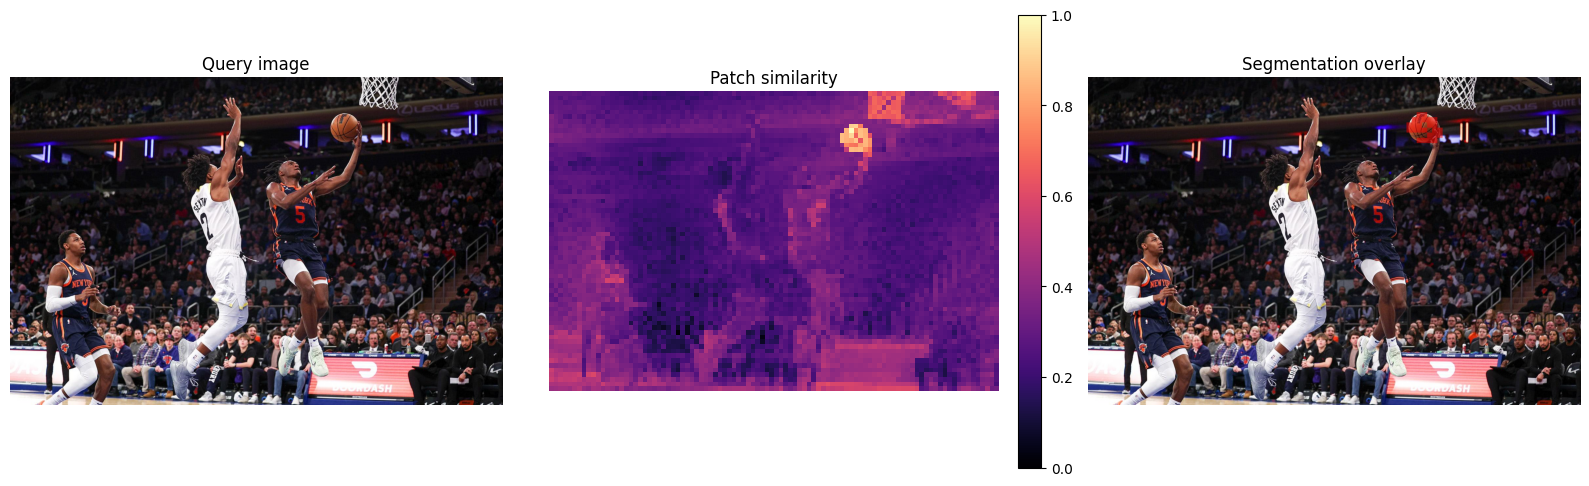

In [ ]:
# =========================
# Pipeline
# =========================
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- tiny helpers for this cell ---

def read_rgb(path):
    """Read an image from disk as RGB PIL.Image."""
    return Image.open(str(path)).convert("RGB")

def upsample_to_image(mask_hw, target_hw):
    """Upsample a (Hp,Wp) mask to (H,W) with nearest."""
    H, W = target_hw
    m = mask_hw.unsqueeze(0).unsqueeze(0).float()    # 1x1xHp xWp
    m_up = F.interpolate(m, size=(H, W), mode="nearest").squeeze(0).squeeze(0)
    return (m_up > 0.5).to(torch.uint8)              # keep it binary

def overlay_mask_on_image(img_np, mask_np, alpha=0.5):
    """Overlay a binary mask (H,W) over an RGB image (H,W,3) with a red tint."""
    if img_np.dtype != np.uint8:
        base = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
    else:
        base = img_np.copy()
    color = np.zeros_like(base)
    color[..., 0] = 255  # red
    m3 = np.repeat(mask_np[..., None], 3, axis=2)
    out = base.copy()
    out[m3.astype(bool)] = (
        (1 - alpha) * base[m3.astype(bool)] + alpha * color[m3.astype(bool)]
    ).astype(np.uint8)
    return out


# 1) Load model and transforms
model = load_model_dinov3(MODEL_NAME, DEVICE)                    # es: 'vit_small_plus_patch16_dinov3_qkvb.lvd_1689m'
transform = get_dinov3_transform_preserving_aspect_ratio(model, force_size=INPUT_SIZE) # es: INPUT_SIZE=256 (short side)

# 2) Load images (PIL)
q_pil = read_rgb(QUERY_IMAGE_PATH)
s_pil = read_rgb(SUPPORT_IMAGE_PATH)
q_np  = np.array(q_pil)  # keep original for visualization
print(f"[DEBUG] Query PIL size (W,H): {q_pil.size}")
print(f"[DEBUG] Support PIL size (W,H): {s_pil.size}")

# 3) Feature maps (C, Hp, Wp) — pass PIL to the extractor (transform inside)
q_fmap = extract_from_layer_dinov3(q_pil, model, transform, DEVICE, mask_hw=None, verbose=True)
s_fmap = extract_from_layer_dinov3(s_pil, model, transform, DEVICE, mask_hw=None, verbose=True)

# 4) Build a support embedding (from mask if provided, else global average)
if SUPPORT_MASK_PATH is not None:
    m_pil = Image.open(str(SUPPORT_MASK_PATH)).convert("L")
    m_np  = (np.array(m_pil) > 127).astype(np.uint8)      # binarize at 128
    m_t   = torch.from_numpy(m_np)                        # (Hs_img, Ws_img)

    # Masked embedding directly from support PIL (extractor handles resize)
    s_emb = extract_from_layer_dinov3(
        s_pil, model, transform, DEVICE,
        mask_hw=m_t.to(DEVICE), verbose=True
    )  # (C,)
else:
    # Global average over support fmap
    s_emb = s_fmap.view(s_fmap.shape[0], -1).mean(dim=1)  # (C,)

print(f"[DEBUG] Feature dim (C): {q_fmap.shape[0]}")
print(f"[DEBUG] Query grid: {tuple(q_fmap.shape[1:])} | Support grid: {tuple(s_fmap.shape[1:])}")

# 5) Similarity on the query
q_sim = compute_similarity_map(q_fmap, s_emb, normalize=True)  # (Hq, Wq)
print(f"[DEBUG] q_sim stats: min={q_sim.min().item():.4f}  max={q_sim.max().item():.4f}  mean={q_sim.mean().item():.4f}  std={q_sim.std().item():.4f}")

# 6) Threshold to get a patch-level binary mask
q_mask_patch = extract_mask(
    q_sim,
    mode=MASK_MODE,                      # "threshold" | "topk%"
    tval=THRESH_VALUE,                   # es: if 'max' try 0.7–0.85; if 'topk%' try 0.01–0.03
    threshold_type=THRESHOLD_TYPE,       # "static" | "mean_std" | "max"
    closing_kernel_size=MORPH_CLOSING_KSIZE,
    min_area=SMALL_COMPONENT_AREA,
    keep_largest_cc=KEEP_LARGEST_CC,     # True if single object
)
print(f"[DEBUG] q_mask_patch pos_ratio={q_mask_patch.float().mean().item():.4f}")

# 7) Upsample mask to image resolution (for visualization)
q_mask_img = upsample_to_image(q_mask_patch, target_hw=(q_np.shape[0], q_np.shape[1])).cpu().numpy()

# 8) Debug: dimensions seen by the model (apply transform to PIL!)
img_tfm = transform(q_pil)   # (3, Ht, Wt)
Ht, Wt = img_tfm.shape[-2:]
print(f"[DEBUG] Query image shape      : {q_np.shape} (H,W,C)")
print(f"[DEBUG] Model input size       : {(Ht, Wt)} (H,W) — after aspect-ratio resize (+ padding if enabled)")
print(f"[DEBUG] Patch feature map shape: {q_fmap.shape[1:]} (Hp,Wp)")
print(f"[DEBUG] Final mask shape       : {q_mask_img.shape} (H,W)")

# 9) Visualize: query image, similarity heatmap, overlay
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(q_np); axs[0].set_title("Query image"); axs[0].axis("off")

im1 = axs[1].imshow(q_sim.cpu().numpy(), cmap="magma")
axs[1].set_title("Patch similarity"); axs[1].axis("off")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

overlay = overlay_mask_on_image(q_np, q_mask_img, alpha=0.5)
axs[2].imshow(overlay); axs[2].set_title("Segmentation overlay"); axs[2].axis("off")

plt.tight_layout()
plt.show()


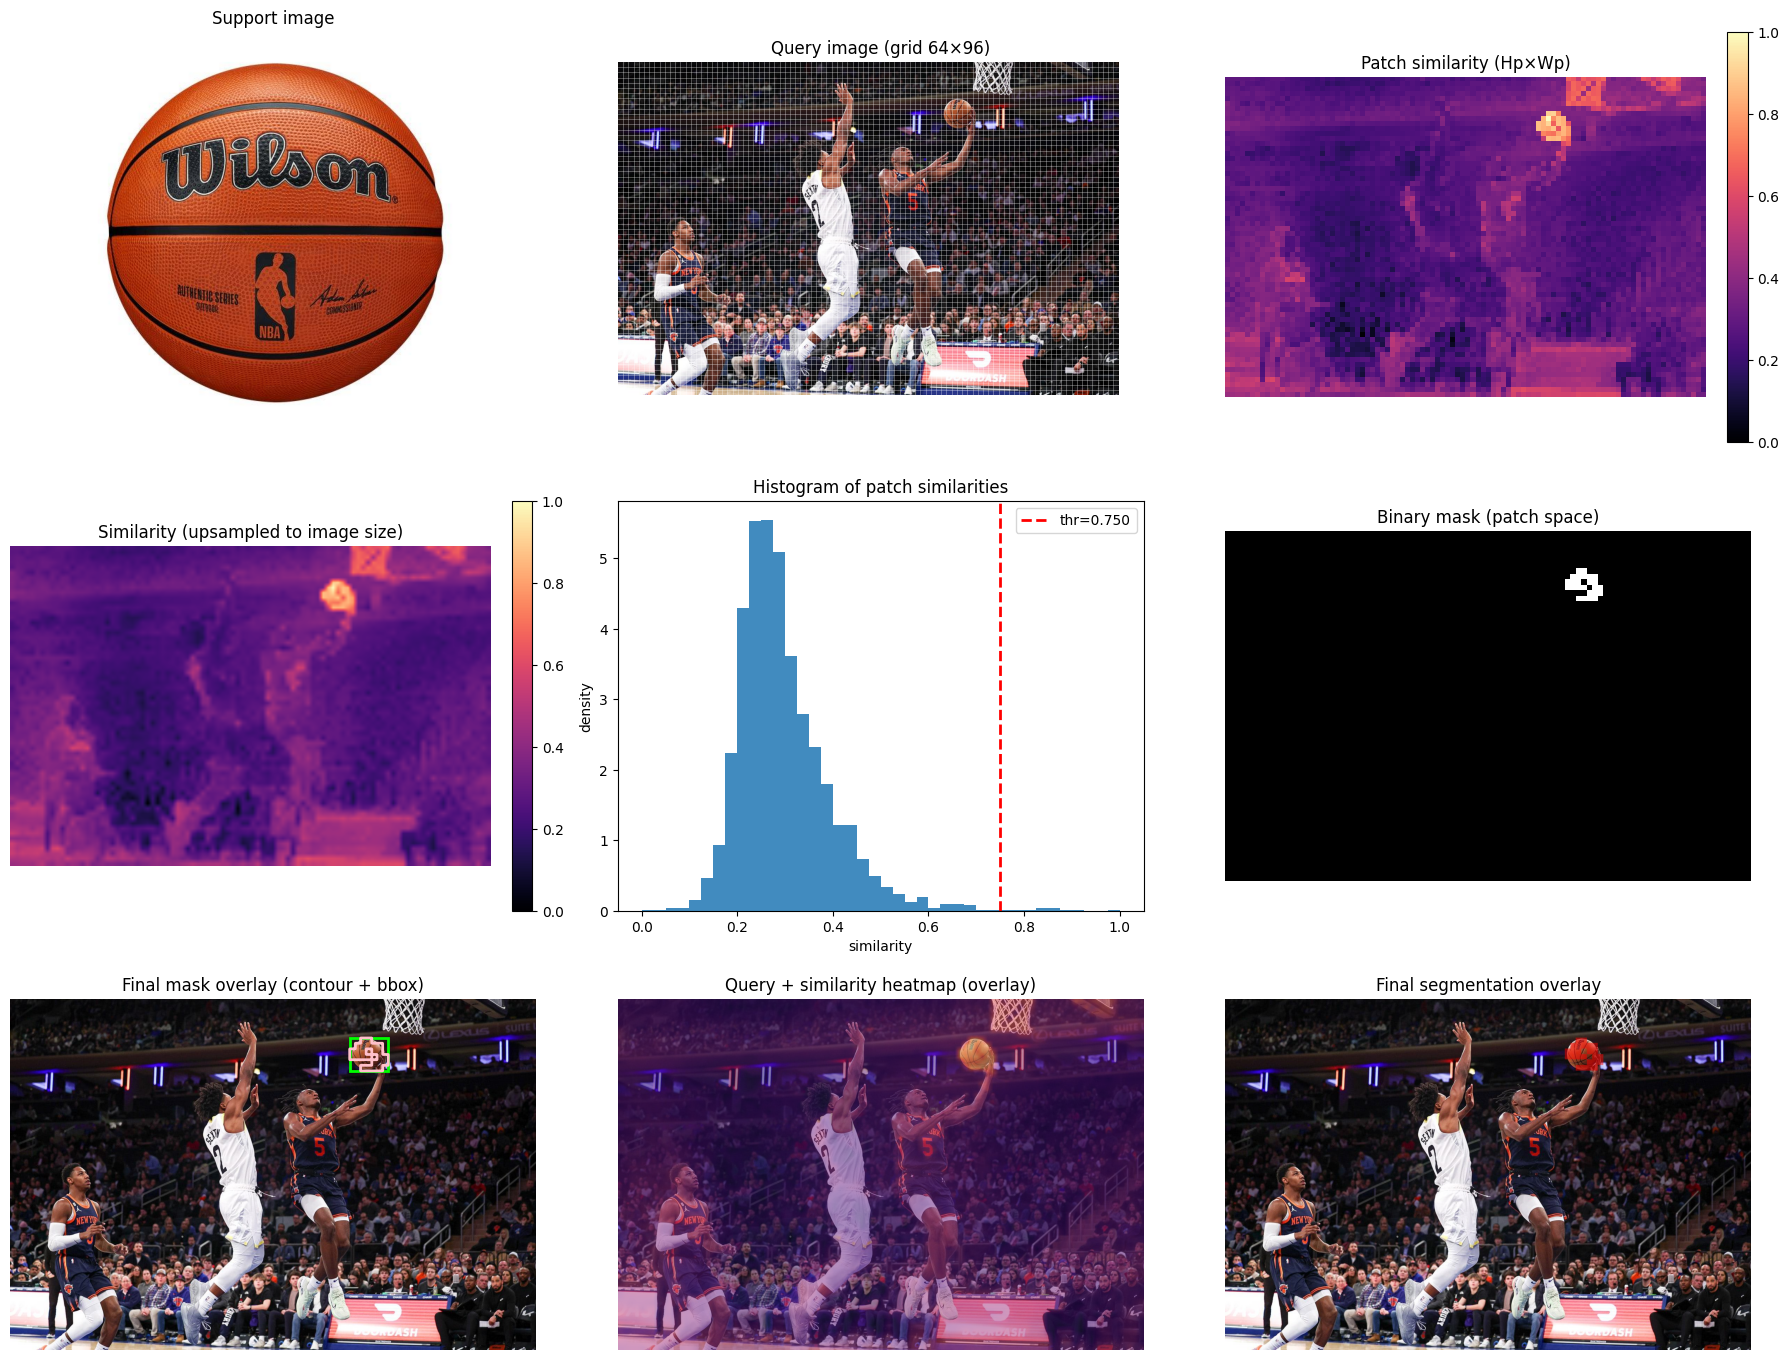

[EXTRA DEBUG] Query image: (1000, 1500, 3) (H,W,C)
[EXTRA DEBUG] Patch grid:  64×96
[EXTRA DEBUG] Mask (img):  (1000, 1500)
[EXTRA DEBUG] BBox:        (110, 969, 203, 1078)


In [ ]:
# =========================
# Extra visualizations (sanity & explainability)
# =========================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F



# --- derive/prepare items we already computed in the main pipeline ---
Hp, Wp = q_sim.shape
H_img, W_img = q_np.shape[:2]

# upsample similarity to image size for nicer overlays
q_sim_up = F.interpolate(
    q_sim.unsqueeze(0).unsqueeze(0),
    size=(H_img, W_img),
    mode="bilinear",
    align_corners=False
).squeeze(0).squeeze(0).cpu().numpy()

# optional: support mask overlay (if present)
support_np = np.array(s_pil)
if SUPPORT_MASK_PATH is not None:
    s_mask_np = (np.array(Image.open(str(SUPPORT_MASK_PATH)).convert("L")) > 127).astype(np.uint8)
else:
    s_mask_np = None

# bounding box from final upsampled mask
bbox = compute_bbox_from_mask(q_mask_img)

# --- FIGURE LAYOUT ---
fig = plt.figure(figsize=(18, 14))

# (1) Support image (+ mask overlay if present)
ax1 = plt.subplot(3, 3, 1)
ax1.imshow(support_np)
ax1.set_title("Support image")
ax1.axis("off")
if s_mask_np is not None:
    # draw semi-transparent green where mask=1
    overlay = support_np.copy()
    green = np.zeros_like(overlay); green[..., 1] = 255
    m3 = np.repeat(s_mask_np[..., None], 3, axis=2).astype(bool)
    overlay[m3] = (0.5 * overlay[m3] + 0.5 * green[m3]).astype(np.uint8)
    ax1.imshow(overlay, alpha=0.6)
    ax1.set_title("Support image + mask")

# (2) Query image + patch grid
ax2 = plt.subplot(3, 3, 2)
ax2.imshow(q_np)
ax2.set_title(f"Query image (grid {Hp}×{Wp})")
ax2.axis("off")
draw_patch_grid(ax2, H_img, W_img, Hp, Wp, color='white', lw=0.6, alpha=0.35)

# (3) Similarity @ patch resolution
ax3 = plt.subplot(3, 3, 3)
im3 = ax3.imshow(q_sim.cpu().numpy(), cmap="magma", vmin=0, vmax=1)
ax3.set_title("Patch similarity (Hp×Wp)")
ax3.axis("off")
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

# (4) Similarity upsampled to image size (pretty)
ax4 = plt.subplot(3, 3, 4)
im4 = ax4.imshow(q_sim_up, cmap="magma", vmin=0, vmax=1)
ax4.set_title("Similarity (upsampled to image size)")
ax4.axis("off")
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

# (5) Histogram of patch similarities with threshold line
ax5 = plt.subplot(3, 3, 5)
vals = q_sim.flatten().cpu().numpy()
ax5.hist(vals, bins=40, density=True, alpha=0.85)
ax5.set_title("Histogram of patch similarities")
ax5.set_xlabel("similarity")
ax5.set_ylabel("density")
# draw threshold if using 'threshold' mode
if MASK_MODE == "threshold":
    if THRESHOLD_TYPE == "static":
        thr_line = THRESH_VALUE
    elif THRESHOLD_TYPE == "mean_std":
        thr_line = vals.mean() + THRESH_VALUE * vals.std()
    elif THRESHOLD_TYPE == "max":
        thr_line = THRESH_VALUE * float(vals.max())
    else:
        thr_line = None
    if thr_line is not None:
        ax5.axvline(thr_line, color="red", ls="--", lw=2, label=f"thr={thr_line:.3f}")
        ax5.legend()

# (6) Binary mask at patch resolution
ax6 = plt.subplot(3, 3, 6)
ax6.imshow(q_mask_patch.cpu().numpy(), cmap="gray")
ax6.set_title("Binary mask (patch space)")
ax6.axis("off")

# (7) Final mask upsampled + contour & bbox
ax7 = plt.subplot(3, 3, 7)
ax7.imshow(q_np)
ax7.set_title("Final mask overlay (contour + bbox)")
ax7.axis("off")
# draw contour from mask
contour = plt.contour(q_mask_img, levels=[0.5], colors=['pink'], linewidths=2)
# draw bounding box
if bbox is not None:
    y0, x0, y1, x1 = bbox
    rect = patches.Rectangle((x0, y0), x1 - x0 + 1, y1 - y0 + 1,
                             linewidth=2, edgecolor='lime', facecolor='none')
    ax7.add_patch(rect)

# (8) Heatmap overlay on image (alpha blend)
ax8 = plt.subplot(3, 3, 8)
ax8.imshow(q_np)
ax8.imshow(q_sim_up, cmap="magma", alpha=0.5, vmin=0, vmax=1)
ax8.set_title("Query + similarity heatmap (overlay)")
ax8.axis("off")

# (9) Final segmentation overlay (red)
ax9 = plt.subplot(3, 3, 9)
final_overlay = overlay_mask_on_image(q_np, q_mask_img, alpha=0.5)
ax9.imshow(final_overlay)
ax9.set_title("Final segmentation overlay")
ax9.axis("off")

plt.tight_layout()
plt.show()

# quick dimensional summary
print(f"[EXTRA DEBUG] Query image: {q_np.shape} (H,W,C)")
print(f"[EXTRA DEBUG] Patch grid:  {Hp}×{Wp}")
print(f"[EXTRA DEBUG] Mask (img):  {q_mask_img.shape}")
print(f"[EXTRA DEBUG] BBox:        {bbox}")
